### Things to fix/implement this PR:
* [x] The inferance is not being run on the GPU despite setting the torch.device to GPU
* [x] Allow optional parameter to specify batch size for batch scoring
* [x] Constructor option to scorer class for specifying version of ResNet to use
* [x] Use formal logging for scorer instead of print statements.

In [1]:
import pandas as pd
from pathlib import Path
from datetime import datetime
from plotnine import *

from modeling_notebooks.resnet_selection.resnet_scorer import OtterScorer, ResNetVersions
from modeling_notebooks.resnet_selection.model_eval_utilities import generate_metric_curves

import torch
import torchvision

oon_data_dir = Path("/mnt/a/data/ott-or-not")
naro_data_dir = oon_data_dir / "north_american_river_otter"

In [2]:
if torch.cuda.is_available():
    notebook_device = torch.device("cuda")
    print(f"Using CUDA backend on device '{torch.cuda.get_device_name(0)}'.")
else:
    notebook_device = torch.device("cpu")
    print("Using CPU backend.")

Using CUDA backend on device 'NVIDIA GeForce RTX 3080 Ti'.


## Record runtimes for model-device combinations

In [3]:
# version = ResNetVersions.v152
# device = torch.device("cpu")
# device = torch.device("cuda")
# scorer = OtterScorer(resnet_version=version, device=device)
# scorer = OtterScorer(resnet_version=version)

In [4]:
# Test batching by reading all the files in the NARO directory

# Resnet-18
# 9.0s on GPU
# 11.0s on CPU

# Resnet-34
# 10.8s on GPU
# 13.1s on CPU

# Resnet-50
# 9.3 on GPU
# 19.6 on CPU

# Resnet-101
# 11.4 on GPU
# 25.4 on CPU

# Resnet-152  Note: this model does not fit in the GPU's memory
# 19m 35.0s on GPU
# 31.6 on CPU

# naro_results = scorer.score_images_in_directory(oon_data_dir, batch_size=64)
# len(naro_results)

## Benchmark performance for each model version
We want to make sure that our selected model will percorm well across all species of otter we want to identify. Later we will also add some similar-but-different examples to classify as well (e.g. beaver, weasel, platypus)

In [5]:
version_device_pairs = [
    (ResNetVersions.v18, torch.device("cuda")),
    (ResNetVersions.v34, torch.device("cuda")),
    (ResNetVersions.v50, torch.device("cuda")),
    (ResNetVersions.v101, torch.device("cuda")),
    (ResNetVersions.v152, torch.device("cpu")),
]

In [6]:
notebook_device.type

'cuda'

In [7]:
model_result_records = list()
model_scoring_runtime = dict()

for version, device in version_device_pairs:
    version_name = f"ResNet-{version.value}"
    print(f"Scoring with {version_name} on {device.type}")
    scorer = OtterScorer(resnet_version=version, device=device)
    
    start_time = datetime.now()
    results = scorer.score_images_in_directory(oon_data_dir, batch_size=32, silent=True)
    end_time = datetime.now()
    model_scoring_runtime[version_name] = end_time - start_time

    for result in results:
        species = result.file_path.parent.name

        model_result_records.append({
            "model_version": version.value,
            "model_version_name": version_name,
            "device": device.type,
            "file_path": result.file_path,
            "true_species": species,
            "resnet_category": result.category,
            "resnet_category_score": result.category_score,
            "resnet_is_otter_category": "otter"  if result.category == "otter" else "not_otter",
            "resnet_is_otter_score": result.otter_score,
            "actual_image_is_otter": True if "otter" in species else False,

        })

        # Clean up our memory once we are done with the model so
        # that we are playing nice with other users of the GPU
        scorer = None
        torch.cuda.empty_cache()

# Assemble the results into a DataFrame
model_result_df = pd.DataFrame(model_result_records)
model_result_df.shape

Scoring with ResNet-18 on cuda


/home/cpbonnell/projects/ott-or-not/modeling_notebooks/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)


Scoring with ResNet-34 on cuda
Scoring with ResNet-50 on cuda
Scoring with ResNet-101 on cuda
Scoring with ResNet-152 on cpu


(5810, 10)

In [8]:
model_scoring_runtime

{'ResNet-18': datetime.timedelta(seconds=50, microseconds=394350),
 'ResNet-34': datetime.timedelta(seconds=45, microseconds=78200),
 'ResNet-50': datetime.timedelta(seconds=45, microseconds=869737),
 'ResNet-101': datetime.timedelta(seconds=45, microseconds=214676),
 'ResNet-152': datetime.timedelta(seconds=134, microseconds=586809)}

In [9]:
metric_curves = generate_metric_curves(
    model_result_df,
    model_colname="model_version_name",
    true_category_colname="actual_image_is_otter",
    score_colname="resnet_is_otter_score",
)

metric_curves.head(5)

,model_name,threshold,true_positive_count,false_positive_count,true_negative_count,false_negative_count,true_positive_rate,false_positive_rate,precision,recall
0,ResNet-18,0.00,618,544,0,0,1.000000,1.000000,0.531842,1.000000
1,ResNet-18,0.01,568,131,413,50,0.919094,0.240809,0.812589,0.919094
2,ResNet-18,0.02,558,91,453,60,0.902913,0.167279,0.859784,0.902913
3,ResNet-18,0.03,549,68,476,69,0.888350,0.125000,0.889789,0.888350
4,ResNet-18,0.04,541,60,484,77,0.875405,0.110294,0.900166,0.875405


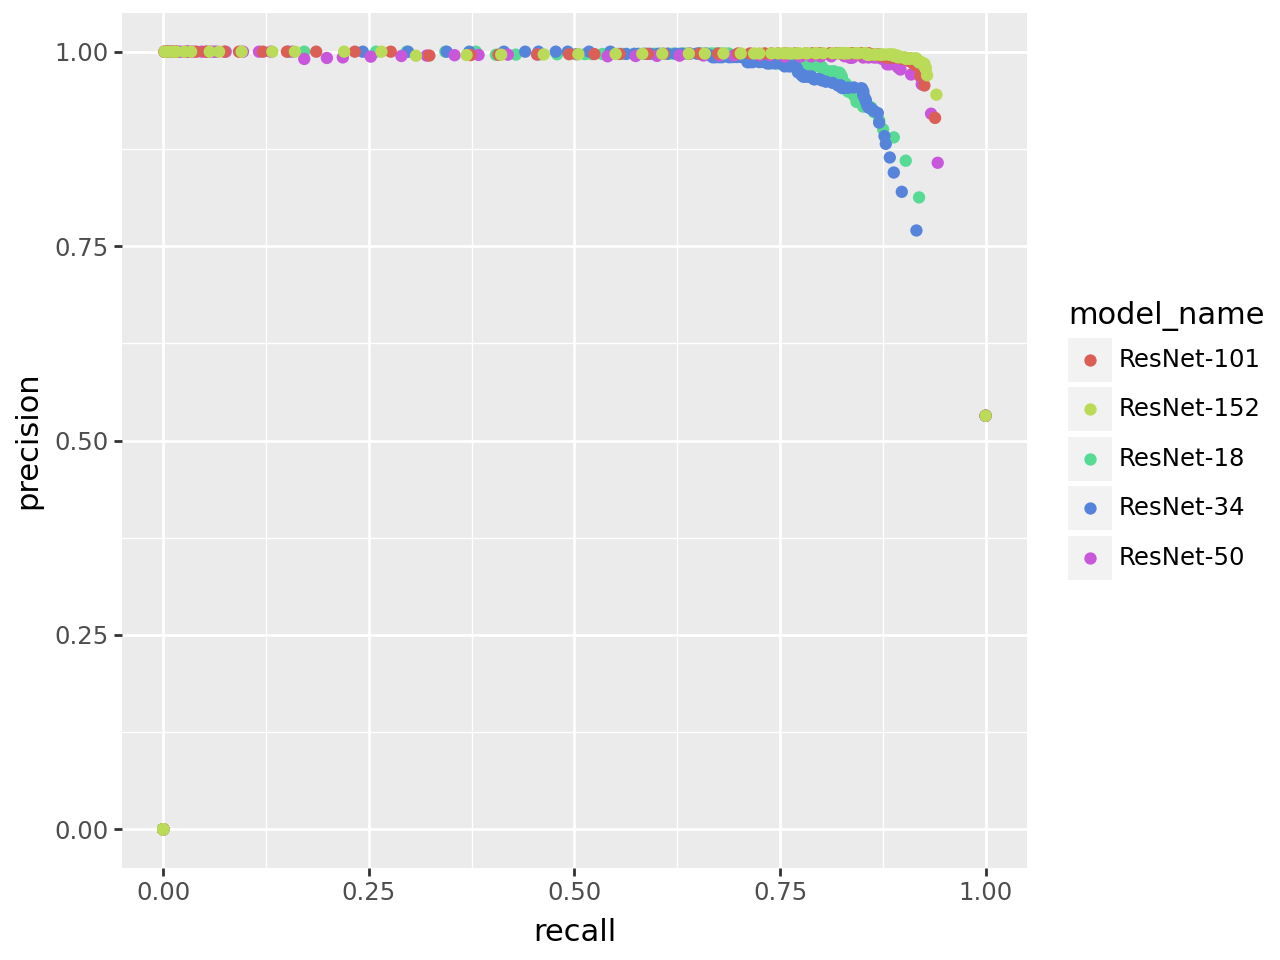

In [10]:
ggplot(metric_curves, aes(x="recall", y="precision", color="model_name")) + geom_point()

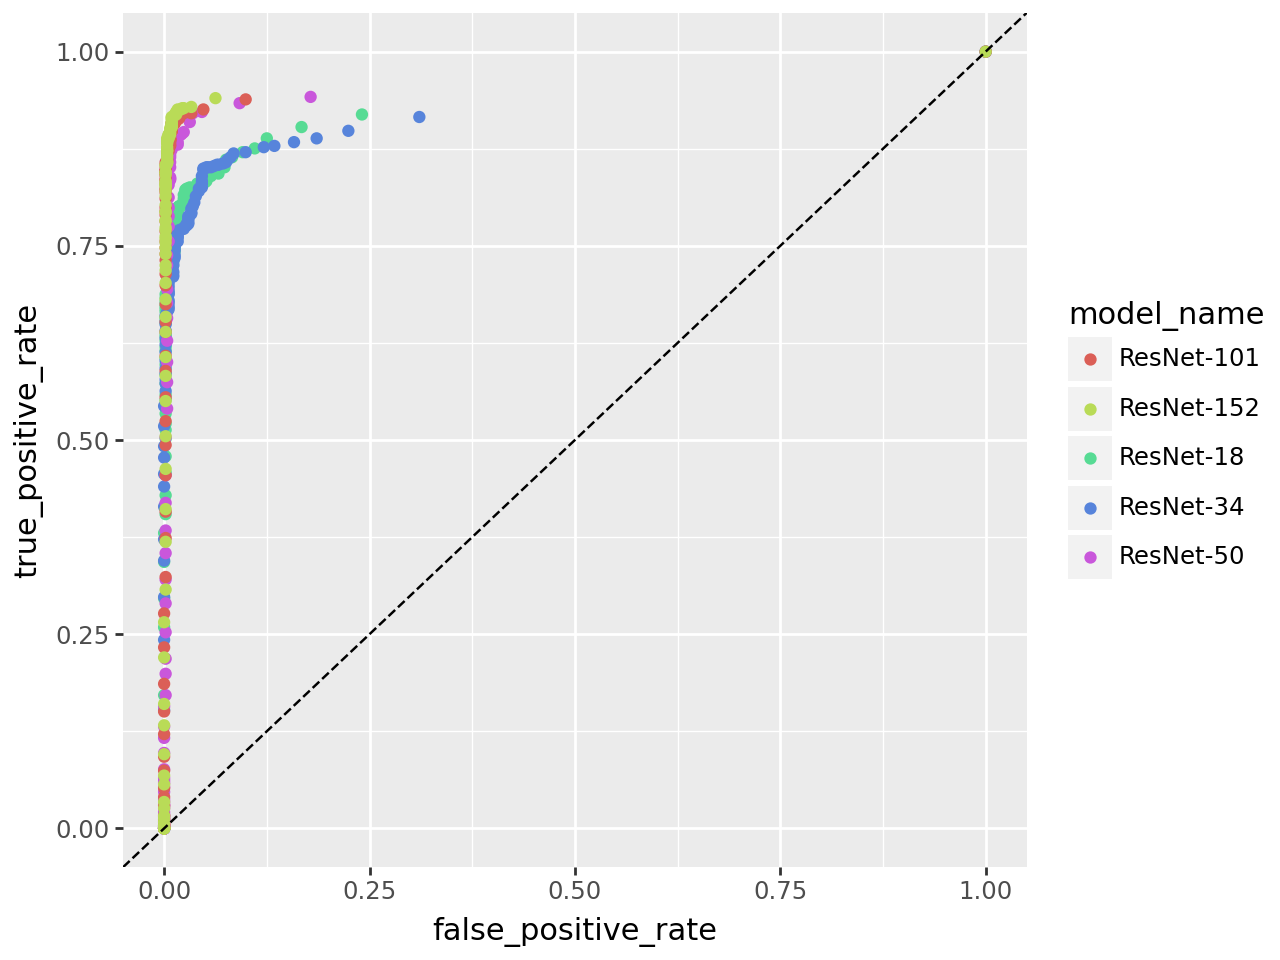

In [11]:
# ROC curve
(
    ggplot(metric_curves, aes(x="false_positive_rate", y="true_positive_rate", color="model_name")) + 
    geom_point() + 
    geom_abline(linetype="dashed", slope=1, intercept=0) +
    scale_x_continuous(limits=(0, 1)) +
    scale_y_continuous(limits=(0, 1))
)

## Notes on surface level evaluation
All of the models are very good, and at a cursury glance ResNet 50, 101 and 152 do provide noticable lift over 18 and 34, but but the 3 larget models all have comparable performance. 

This seems to recommend the use of ResNet-50 for the base Otter/Not-Otter classification, but an examination of the exact images misclassified by the models will be needed before the final determination. Then an exact counts of mistakes made can be assembled.

In [ ]:
# Get a scorer so that we can use it to look at processed images
scorer = OtterScorer(resnet_version=ResNetVersions.v152)

In [13]:
misclassed_as_otter = model_result_df[
    (model_result_df["model_version"] == 152) &
    (model_result_df["actual_image_is_otter"] == False) &
    (model_result_df["resnet_is_otter_category"] == "otter")
]
misclassed_as_otter.sort_values("resnet_is_otter_score", ascending=False).head()

,model_version,model_version_name,device,file_path,true_species,resnet_category,resnet_category_score,resnet_is_otter_category,resnet_is_otter_score,actual_image_is_otter
5171,152,ResNet-152,cpu,/mnt/a/data/ott-or-not/muskrat/FL090625_D090-s...,muskrat,otter,0.792739,otter,0.792739,False
5222,152,ResNet-152,cpu,/mnt/a/data/ott-or-not/muskrat/MuskratThumbnai...,muskrat,otter,0.400706,otter,0.400706,False
4800,152,ResNet-152,cpu,/mnt/a/data/ott-or-not/beaver/A1zcl4eTfBL._AC_...,beaver,otter,0.184233,otter,0.184233,False


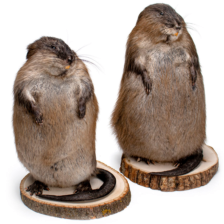

In [27]:
p = misclassed_as_otter.loc[5222]["file_path"]
scorer.preprocess_image(p)

In [28]:
misclassed_as_not_otter = model_result_df[
    (model_result_df["model_version"] == 152) &
    (model_result_df["actual_image_is_otter"] == True) &
    (model_result_df["resnet_is_otter_category"] != "otter")
]
misclassed_as_not_otter.sort_values("resnet_is_otter_score", ascending=True).head()

,model_version,model_version_name,device,file_path,true_species,resnet_category,resnet_category_score,resnet_is_otter_category,resnet_is_otter_score,actual_image_is_otter
4751,152,ResNet-152,cpu,/mnt/a/data/ott-or-not/asian_small_clawed_otte...,asian_small_clawed_otter,nipple,0.507096,not_otter,0.343277,True
5345,152,ResNet-152,cpu,/mnt/a/data/ott-or-not/north_american_river_ot...,north_american_river_otter,platypus,0.451886,not_otter,0.303702,True
5668,152,ResNet-152,cpu,/mnt/a/data/ott-or-not/sea_otter/otter-luna-wi...,sea_otter,beaver,0.430390,not_otter,0.277792,True
5755,152,ResNet-152,cpu,/mnt/a/data/ott-or-not/giant_otter/340865314_9...,giant_otter,mink,0.350193,not_otter,0.275824,True
4989,152,ResNet-152,cpu,/mnt/a/data/ott-or-not/giant_otter/A-dreamstim...,giant_otter,sea lion,0.270966,not_otter,0.235727,True


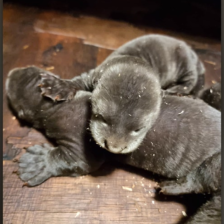

In [33]:
p = misclassed_as_not_otter.loc[5755]["file_path"]
scorer.preprocess_image(p)